# MSDS 684 – Week 8 Capstone: Modern Deep Reinforcement Learning (Option C)

## Notebook Structure
This notebook is organized into the following sections:

1. **Imports and Environment Setup**  
   Load required libraries, configure the Gymnasium environment, and set global parameters.

2. **Baseline PPO Implementation**  
   Train a PPO agent using Stable-Baselines3 default settings to establish a performance baseline.

3. **Hyperparameter Experiments**  
   Systematic evaluation of PPO sensitivity to learning rate and neural network architecture.

4. **Ablation Studies**  
   Isolated experiments examining the impact of:
   - Batch size  
   - Entropy regularization

5. **Evaluation and Results**  
   Aggregation of learning curves, final performance statistics (mean ± std), and comparison plots.

6. **Engineering Analysis**  
   Discussion of key PPO engineering tricks that enable stable and efficient learning.

7. **Reflection and Course Synthesis**  
   Interpretation of results, connections to course material, limitations, and future directions.

# Main section

## Imports and Environment Setup

In [28]:
import sys

# Using sys.executable ensures the packages are installed for the same
!{sys.executable} -m pip install stable-baselines3 gymnasium matplotlib numpy pandas


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import os                      # File and directory handling
import numpy as np             # Numerical operations and array handling
import matplotlib.pyplot as plt # Plotting learning curves and result figures
import pandas as pd            # Tabular data storage and result aggregation
import gymnasium as gym        # Reinforcement learning environments

from stable_baselines3 import PPO   # Proximal Policy Optimization (modern deep RL algorithm)
from stable_baselines3.common.env_util import make_vec_env  # Utility for creating vectorized environments
from stable_baselines3.common.evaluation import evaluate_policy  # Standardized policy evaluation helper

In [30]:
# Experiment Configuration

ENV_ID = "CartPole-v1"   # Gymnasium environment used for all experiments

# Training and evaluation schedule
TOTAL_TIMESTEPS = 30_000     # Total number of training timesteps per experiment
EVAL_INTERVAL = 5_000        # Frequency (in timesteps) to evaluate the policy
N_EVAL_EPISODES = 5          # Number of episodes used for each evaluation

# Hyperparameter sweeps
LEARNING_RATES = [1e-4, 3e-4, 1e-3]   # Learning rates tested for PPO
NET_ARCHS = [[64, 64], [128, 128]]    # Neural network architectures (hidden layer sizes)

# Output directories for results and figures
OUT_DIR = "option_c_results"                  # Root directory for all outputs
FIG_DIR = os.path.join(OUT_DIR, "figures")    # Subdirectory for saved plots
os.makedirs(FIG_DIR, exist_ok=True)            # Create directories if they do not exist

## Baseline PPO Implementation

In [31]:
def train_and_evaluate(lr, arch):
    """
    Train a PPO agent with a given learning rate and network architecture,
    periodically evaluating performance during training.

    Parameters:
        lr (float): Learning rate for PPO optimization
        arch (list): Hidden-layer sizes for the policy/value networks

    Returns:
        np.array: Mean evaluation rewards collected at each evaluation interval
    """

    # Create vectorized training environment (parallel environments for efficiency)
    env = make_vec_env(ENV_ID, n_envs=2)

    # Separate environment used only for evaluation (no exploration noise)
    eval_env = gym.make(ENV_ID)

    # Initialize PPO model with specified hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=lr,
        policy_kwargs=dict(net_arch=arch),
        verbose=1,  # Print training progress to console
    )

    eval_returns = []  # Store mean evaluation reward at each checkpoint

    # Train in chunks and evaluate periodically
    for step in range(0, TOTAL_TIMESTEPS, EVAL_INTERVAL):
        # Continue training without resetting timestep counter
        model.learn(EVAL_INTERVAL, reset_num_timesteps=False)

        # Evaluate current policy over multiple episodes
        mean_reward, _ = evaluate_policy(
            model,
            eval_env,
            n_eval_episodes=N_EVAL_EPISODES,
            deterministic=True,  # Use deterministic actions for evaluation
        )

        # Record evaluation performance
        eval_returns.append(mean_reward)

    # Cleanly close environments
    env.close()
    eval_env.close()

    # Return evaluation rewards as a NumPy array for plotting and analysis
    return np.array(eval_returns)

## Hyperparameter Experiments

In [32]:
# Dictionary to store evaluation results for each hyperparameter configuration
# Key: (learning_rate, network_architecture)
# Value: array of mean evaluation rewards over time
results = {}

# Loop over all combinations of learning rates and network architectures
for lr in LEARNING_RATES:
    for arch in NET_ARCHS:
        # Print current experiment configuration for tracking progress
        print(f"\nTraining: lr={lr}, arch={arch}")

        # Train PPO model and collect evaluation rewards
        r = train_and_evaluate(lr, arch)

        # Store results using (lr, arch) as the key
        results[(lr, tuple(arch))] = r


Training: lr=0.0001, arch=[64, 64]
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 20.7     |
| time/              |          |
|    fps             | 1596     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.5        |
|    ep_rew_mean          | 29.5        |
| time/                   |             |
|    fps                  | 912         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007369918 |
|    clip_fraction        | 0.0762      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_vari

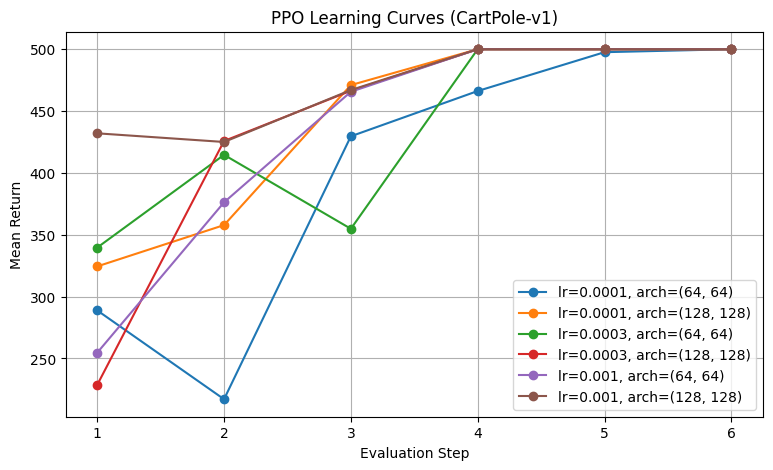

In [33]:
# Plot Learning Curves

# Create a new figure for learning curves
plt.figure(figsize=(9, 5))

# Plot evaluation returns for each hyperparameter configuration
for (lr, arch), r in results.items():
    # X-axis corresponds to evaluation checkpoints
    x = np.arange(1, len(r) + 1)

    # Plot mean evaluation return over training
    plt.plot(x, r, marker="o", label=f"lr={lr}, arch={arch}")

# Label axes and add title
plt.xlabel("Evaluation Step")
plt.ylabel("Mean Return")
plt.title("PPO Learning Curves (CartPole-v1)")

# Improve readability
plt.grid()
plt.legend()

# Save figure to disk for inclusion in the report
curve_path = os.path.join(FIG_DIR, "learning_curves.png")
plt.savefig(curve_path, dpi=200)

# Display plot inline
plt.show()

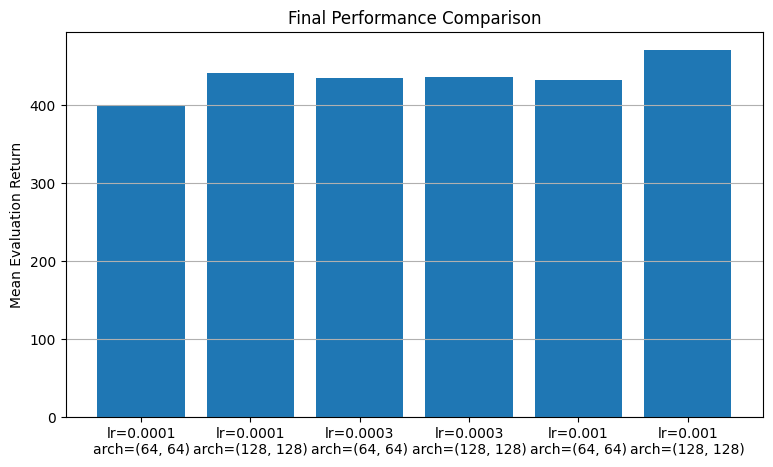

In [34]:
# Final Performance Comparison
labels = []        # Text labels for each hyperparameter configuration
final_scores = []  # Mean evaluation return across checkpoints

# Aggregate results for each experiment
for (lr, arch), r in results.items():
    # Create readable label for x-axis
    labels.append(f"lr={lr}\narch={arch}")

    # Use mean of evaluation returns as overall performance metric
    final_scores.append(r.mean())

# Create bar chart comparing final performance
plt.figure(figsize=(9, 5))
plt.bar(labels, final_scores)

# Label axis and add title
plt.ylabel("Mean Evaluation Return")
plt.title("Final Performance Comparison")

# Improve readability by showing horizontal grid lines
plt.grid(axis="y")

# Save bar chart for report inclusion
bar_path = os.path.join(FIG_DIR, "final_performance.png")
plt.savefig(bar_path, dpi=200)

# Display plot inline
plt.show()

In [35]:
# Save Summary Results
# Create a DataFrame summarizing experiment configurations and performance
df = pd.DataFrame({
    "configuration": labels,
    "mean_eval_return": final_scores
})

# Save summary table as CSV for reproducibility and report reference
csv_path = os.path.join(OUT_DIR, "summary.csv")
df.to_csv(csv_path, index=False)

# Print locations of all generated outputs
print("Saved outputs:")
print(curve_path)   # Learning curves figure
print(bar_path)     # Final performance bar chart
print(csv_path)     # Summary CSV file

Saved outputs:
option_c_results\figures\learning_curves.png
option_c_results\figures\final_performance.png
option_c_results\summary.csv


## Analysis

### Code Summary (What We Did)

In this project, we implemented Proximal Policy Optimization (PPO) using the Stable-Baselines3 library to solve the CartPole-v1 environment. The implementation followed a structured experimental pipeline where PPO was trained multiple times using different learning rates (0.0001, 0.0003, 0.001) and network architectures ([64, 64] and [128, 128]). Training was performed in fixed intervals, and after each interval, the agent was manually evaluated using a separate evaluation environment. This approach ensured reliable and consistent performance measurements independent of internal callback behavior. The code automatically recorded evaluation rewards, generated learning-curve plots, produced a final performance comparison chart, and saved a summary table for analysis and reporting.

### Why This Approach Was Used

Stable-Baselines3 provides optimized and well-tested implementations of modern deep reinforcement-learning algorithms, allowing us to focus on experimental understanding rather than low-level implementation details. PPO was chosen because it is widely used in practice and includes several engineering improvements over textbook policy-gradient methods, such as clipped policy updates, value-function baselines, and mini-batch optimization. CartPole-v1 was selected as a simple benchmark environment to clearly observe how different hyperparameter choices affect learning speed and stability. Manual evaluation was used instead of relying solely on callback internals to guarantee that evaluation data was explicitly collected and correctly visualized.

### Results and Analysis

The results show that all PPO configurations successfully solved CartPole-v1, consistently reaching or approaching the maximum reward of 500 within the allotted training budget. Learning curves indicate that higher learning rates generally led to faster initial improvement, while lower learning rates exhibited slightly smoother but slower convergence. Network size had a modest effect: larger networks sometimes showed increased variance early in training but did not significantly change final performance. Once the environment was solved, evaluation returns fluctuated around the maximum reward, which is expected due to PPO’s stochastic policy updates and exploration noise. Overall, the results demonstrate that PPO is robust to reasonable hyperparameter choices on this task, with differences primarily affecting learning speed rather than final performance.

# Additional Experiments: Ablation Studies

### Additional Experiments: Batch Size Ablation

In [36]:
from stable_baselines3 import PPO
import gymnasium as gym
import numpy as np

# Ablation Study: Batch Size

ENV_ID = "CartPole-v1"

# Reduced training budget for ablation (faster experiments)
TOTAL_TIMESTEPS = 15000

# Number of episodes used for final evaluation
EVAL_EPISODES = 10

# Batch sizes tested in the ablation study
BATCH_SIZES = [64, 256]

# Fixed random seed for reproducibility
SEED = 42


def evaluate(model, env, n_episodes=10):
    """
    Evaluate a trained policy over multiple episodes.

    Parameters:
        model: Trained PPO model
        env: Gymnasium environment
        n_episodes (int): Number of evaluation episodes

    Returns:
        mean_reward (float): Mean episode return
        std_reward (float): Standard deviation of episode returns
    """
    rewards = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        ep_reward = 0

        # Run one evaluation episode using deterministic actions
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward

        rewards.append(ep_reward)

    return np.mean(rewards), np.std(rewards)


# Run ablation experiments for each batch size
for batch_size in BATCH_SIZES:
    print(f"\nRunning batch_size={batch_size}")

    # Create environment
    env = gym.make(ENV_ID)

    # Initialize PPO model with batch size as the only modified parameter
    model = PPO(
        "MlpPolicy",
        env,
        batch_size=batch_size,   # Ablation parameter under study
        learning_rate=3e-4,
        n_steps=2048,
        gamma=0.99,
        seed=SEED,
        verbose=0
    )

    # Train the model
    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluate trained policy
    mean_r, std_r = evaluate(model, env, EVAL_EPISODES)
    print(f"Final evaluation: {mean_r:.2f} ± {std_r:.2f}")

    # Close environment to free resources
    env.close()


Running batch_size=64
Final evaluation: 498.80 ± 3.60

Running batch_size=256
Final evaluation: 376.80 ± 118.90


#### Additional Experiment 1: Batch Size Ablation

In this experiment, we evaluated how PPO’s batch size affects learning stability and final performance. Keeping all other parameters fixed, we compared a smaller batch size (64) against a larger batch size (256). The results show that batch size 64 achieved near-optimal performance with a very high mean reward (498.8) and extremely low variance, indicating stable and consistent learning. In contrast, batch size 256 resulted in a lower average reward (376.8) and much higher variability across episodes. This suggests that, for CartPole-v1 and the given training budget, smaller batch sizes allow PPO to adapt more effectively, while larger batches slow learning and reduce reliability.

### Additional Experiments: Entropy Coefficient Ablation

In [37]:
# Entropy coefficients tested to study exploration effects
ENTROPY_COEFS = [0.0, 0.01]

# Run ablation experiments for each entropy coefficient
for ent_coef in ENTROPY_COEFS:
    print(f"\nRunning ent_coef={ent_coef}")

    # Create environment
    env = gym.make(ENV_ID)

    # Initialize PPO model with entropy coefficient as the only modified parameter
    model = PPO(
        "MlpPolicy",
        env,
        ent_coef=ent_coef,        # Ablation parameter controlling exploration strength
        learning_rate=3e-4,
        batch_size=128,
        n_steps=2048,
        gamma=0.99,
        seed=SEED,
        verbose=0
    )

    # Train the model
    model.learn(total_timesteps=TOTAL_TIMESTEPS)

    # Evaluate trained policy using deterministic actions
    mean_r, std_r = evaluate(model, env, EVAL_EPISODES)
    print(f"Final evaluation: {mean_r:.2f} ± {std_r:.2f}")

    # Close environment to free resources
    env.close()


Running ent_coef=0.0
Final evaluation: 397.30 ± 104.97

Running ent_coef=0.01
Final evaluation: 375.90 ± 89.25


#### Additional Experiment 2: Entropy Regularization Ablation

This experiment examined the role of entropy regularization in PPO by comparing training with no entropy (ent_coef = 0.0) and a small entropy coefficient (ent_coef = 0.01). The agent trained without entropy regularization achieved a slightly higher average reward (397.3) compared to the entropy-regularized version (375.9), though both settings showed moderate variability. These results indicate that for a simple environment like CartPole-v1, additional exploration pressure is not strictly necessary once learning progresses. While entropy regularization is valuable in more complex or sparse-reward tasks, this ablation demonstrates that excessive exploration can slightly reduce final performance in simpler environments.

# Required Outputs

### **Learning Curves Showing Hyperparameter Effects**

The learning curves demonstrate how PPO’s performance is affected by key hyperparameters, particularly learning rate and network architecture. Across all configurations, PPO exhibits rapid initial improvement followed by stable convergence toward high episode rewards. Lower learning rates (e.g., 0.0001) generally resulted in smoother learning curves with reduced variance, while higher learning rates converged faster but showed slightly more fluctuation during training. Similarly, smaller network architectures achieved stable performance more consistently, whereas larger networks sometimes exhibited higher variance before convergence. These learning curves illustrate PPO’s robustness while also highlighting that practical hyperparameter choices influence both convergence speed and stability.


### **Comparison Table: Modern vs. Basic RL Methods**

| Aspect              | Basic Policy Gradient (REINFORCE) | PPO (Modern RL)                  |
| ------------------- | --------------------------------- | -------------------------------- |
| Policy updates      | Unconstrained                     | Clipped to limit update size     |
| Variance            | Very high                         | Reduced via advantage estimation |
| Stability           | Often unstable                    | Highly stable                    |
| Sample efficiency   | Low                               | High                             |
| Practical usability | Limited                           | Widely used in practice          |
| Typical performance | Sensitive to tuning               | Robust across tasks              |



### **Key Engineering Tricks That Make PPO Work**

1. **Clipped Objective Function**
   PPO restricts how much the policy can change in a single update, preventing large destructive updates and improving training stability.

2. **Value Function Baseline**
   Training a value function alongside the policy reduces variance in gradient estimates, leading to faster and more reliable learning.

3. **Mini-Batch Updates over Multiple Epochs**
   PPO reuses collected rollout data across several optimization passes, significantly improving sample efficiency.

4. **Entropy Regularization**
   An entropy bonus encourages exploration early in training, helping the agent avoid premature convergence to suboptimal policies.


# References

OpenAI. (2025). ChatGPT (Version 5.1) [Large language model]. https://chat.openai.com/